# Optimal control

**Goal**: Given the avaiable control Hamiltonian $H_j$. Find the time-depdent coefficient $c_j(t)$ such that the Hamiltonian
$H_0+\sum_j c_j(t) H_j$ generates the desired unitary.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip_qip.algorithms import qft
import qutip.logging_utils as logging
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen


In [2]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Si = 0.5*identity(2)

# Drift Hamiltonian
H_d = 0.5*(tensor(Sx, Sx) + tensor(Sy, Sy) + tensor(Sz, Sz))
# The (four) control Hamiltonians
H_c = [tensor(Sx, Si), tensor(Sy, Si), tensor(Si, Sx), tensor(Si, Sy)]
n_ctrls = len(H_c)
# start point for the gate evolution
U_0 = identity(4)
# Target for the gate evolution - Quantum Fourier Transform gate
U_targ = qft(2)

In [3]:
# Fidelity error target
fid_err_targ = 1e-5
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

In [4]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'LIN'
f_ext = None

In [5]:
def optimization(evo_time, verbose=True):
    # Duration of each timeslot
    dt = 0.05
    # Evolution time
    evo_time = evo_time
    n_ts = int(float(evo_time) / dt)
    if not verbose:
        log_level = logging.INFO
    else:
        log_level = logging.ERROR

    optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                    amp_lbound=-5.0, amp_ubound=5.0, 
                    fid_err_targ=fid_err_targ, min_grad=min_grad, 
                    max_iter=max_iter, max_wall_time=max_wall_time, 
                    optim_method='fmin_l_bfgs_b',
                    method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                    dyn_type='UNIT', 
                    fid_params={'phase_option':'PSU'},
                    init_pulse_type=p_type, 
                    log_level=log_level,
                    gen_stats=True)

    # **** get handles to the other objects ****
    dyn = optim.dynamics
    p_gen = optim.pulse_generator

    # Generate the tau (duration) and time (cumulative) arrays
    # so that it can be used to create the pulse generator
    # with matching timeslots
    dyn.init_timeslots()

    # Create a new pulse generator for the new dynamics
    p_gen = pulsegen.create_pulse_gen(p_type, dyn)

    #Generate different initial pulses for each of the controls
    init_amps = np.zeros([n_ts, n_ctrls])
    if (p_gen.periodic):
        phase_diff = np.pi / n_ctrls
        for j in range(n_ctrls):
            init_amps[:, j] = p_gen.gen_pulse(start_phase=phase_diff*j)
    elif (isinstance(p_gen, pulsegen.PulseGenLinear)):
        for j in range(n_ctrls):
            p_gen.scaling = float(j) - float(n_ctrls - 1)/2
            init_amps[:, j] = p_gen.gen_pulse()
    elif (isinstance(p_gen, pulsegen.PulseGenZero)):
        for j in range(n_ctrls):
            p_gen.offset = sf = float(j) - float(n_ctrls - 1)/2
            init_amps[:, j] = p_gen.gen_pulse()


    dyn.initialize_controls(init_amps)

    if verbose:
        print("***********************************")
        print("\n+++++++++++++++++++++++++++++++++++")
        print("Starting pulse optimisation for T={}".format(evo_time))
        print("+++++++++++++++++++++++++++++++++++\n")
    result = optim.run_optimization()

    # Report the results
    if verbose:
        result.stats.report()
        print("Final evolution\n{}\n".format(result.evo_full_final))
        print("********* Summary *****************")
        print("Final fidelity error {}".format(result.fid_err))
        print("Final gradient normal {}".format(result.grad_norm_final))
        print("Terminated due to {}".format(result.termination_reason))
        print("Number of iterations {}".format(result.num_iter))
        print("Completed in {} HH:MM:SS.US".format(
                datetime.timedelta(seconds=result.wall_time)))
    return result

***********************************

+++++++++++++++++++++++++++++++++++
Starting pulse optimisation for T=6
+++++++++++++++++++++++++++++++++++


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:02.249328
Wall time computing Hamiltonians: 0:00:00.125631 (5.59%)
Wall time computing propagators: 0:00:01.593662 (70.85%)
Wall time computing forward propagation: 0:00:00.014167 (0.63%)
Wall time computing onward propagation: 0:00:00.014355 (0.64%)
Wall time computing gradient: 0:00:00.329068 (14.63%)

**** Iterations and function calls ****
Number of iterations: 24
Number of fidelity function calls: 30
Number of times fidelity is computed: 30
Number of gradient function calls: 29
Number of times gradients are computed: 29
Number of times timeslot evolution is recomputed: 30

**** Control amplitudes ****
Number of control amplitude updates: 29
Mean number of updates per iteration: 1.208

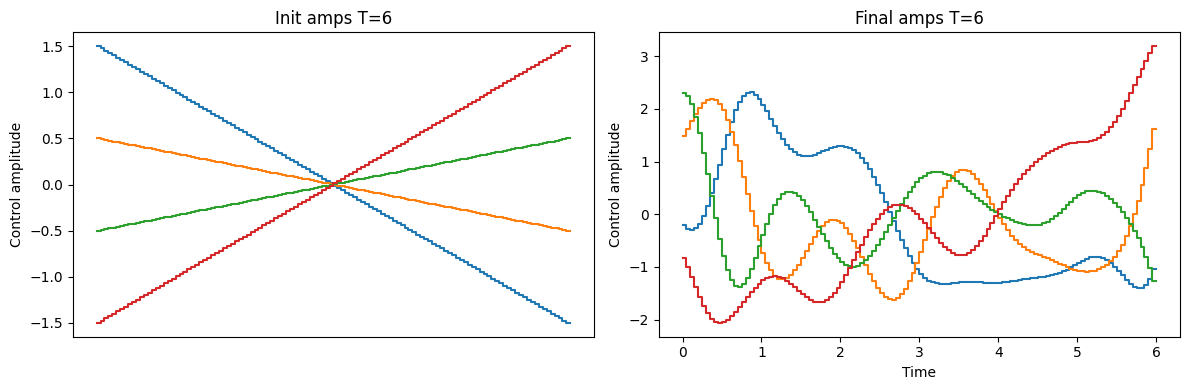

In [6]:
evo_time = 6
result = optimization(evo_time=evo_time)
fig1 = plt.figure(figsize=(12,4))
#Initial amps
ax1 = fig1.add_subplot(1, 2, 1)
ax1.set_title("Init amps T={}".format(evo_time))
# ax1.set_xlabel("Time")
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(result.time, 
         np.hstack((result.initial_amps[:, j], 
                    result.initial_amps[-1, j])), 
             where='post')

ax2 = fig1.add_subplot(1, 2, 2)
ax2.set_title("Final amps T={}".format(evo_time))
ax2.set_xlabel("Time")
#Optimised amps
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(result.time, 
         np.hstack((result.final_amps[:, j], 
                    result.final_amps[-1, j])), 
             where='post')
plt.tight_layout()
plt.show()

In [7]:
result.evo_full_final

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.4620758 +0.19122715j  0.46151636+0.19126417j  0.46241052+0.19094127j
   0.46213112+0.19102767j]
 [ 0.46199149+0.19151454j -0.19197958+0.46204899j -0.46180318-0.19115039j
   0.19122368-0.46170712j]
 [ 0.46165031+0.19097801j -0.46193761-0.1917004j   0.46197027+0.19137927j
  -0.46218878-0.19133733j]
 [ 0.46216726+0.19134259j  0.19167781-0.46173526j -0.46181095-0.19132534j
  -0.19139753+0.46188943j]]

In [8]:
U_targ

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 5.00000000e-01+0.0000000e+00j  5.00000000e-01+0.0000000e+00j
   5.00000000e-01+0.0000000e+00j  5.00000000e-01+0.0000000e+00j]
 [ 5.00000000e-01+0.0000000e+00j  3.06161700e-17+5.0000000e-01j
  -5.00000000e-01+6.1232340e-17j -9.18485099e-17-5.0000000e-01j]
 [ 5.00000000e-01+0.0000000e+00j -5.00000000e-01+6.1232340e-17j
   5.00000000e-01-1.2246468e-16j -5.00000000e-01+1.8369702e-16j]
 [ 5.00000000e-01+0.0000000e+00j -9.18485099e-17-5.0000000e-01j
  -5.00000000e-01+1.8369702e-16j  2.75545530e-16+5.0000000e-01j]]

# Correlation function

## First-order correlation function
$
g^{(1)}(τ)= \frac{⟨a^†(τ)a(0)⟩}{\sqrt{⟨a^†(τ)a(τ)⟩⟨a^†(0)a(0)⟩}}
$

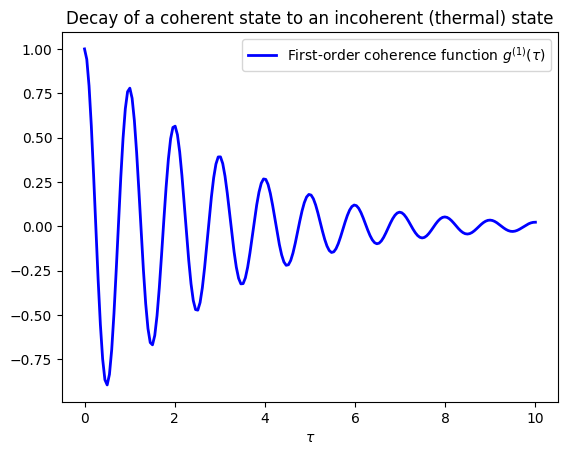

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
N = 15
taus = np.linspace(0,10.0,200)
a = qutip.destroy(N)
H = 2 * np.pi * a.dag() * a

# collapse operator
G1 = 0.75
n_th = 2.00  # bath temperature in terms of excitation number
c_ops = [np.sqrt(G1 * (1 + n_th)) * a, np.sqrt(G1 * n_th) * a.dag()]

# start with a coherent state
rho0 = qutip.coherent_dm(N, 2.0)

# first calculate the occupation number as a function of time
n = qutip.mesolve(H, rho0, taus, c_ops, [a.dag() * a]).expect[0]

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = qutip.correlation_2op_2t(H, rho0, None, taus, c_ops, a.dag(), a)
g1 = G1 / np.sqrt(n[0] * n)

plt.plot(taus, np.real(g1), 'b', lw=2)
# plt.plot(taus, n, 'r', lw=2)
plt.title('Decay of a coherent state to an incoherent (thermal) state')
plt.xlabel(r'$\tau$')
plt.legend([
    r'First-order coherence function $g^{(1)}(\tau)$',
#     r'Occupation number $n(\tau)$',
])

## Second-order correlation function
$
g(2)(τ) = \frac{⟨a^†(0)a^†(τ)a(τ)a(0)⟩}{⟨a^†(0)a(0)⟩^2}
$

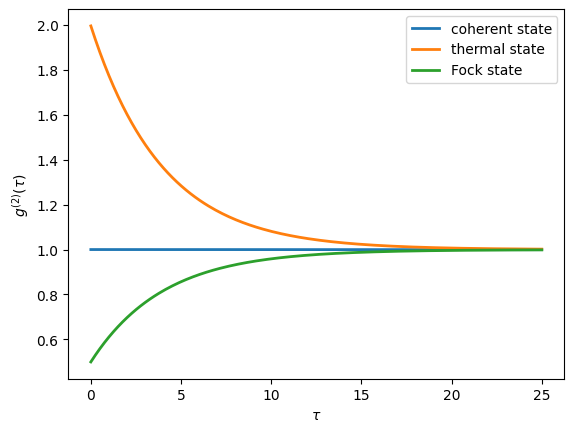

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

N = 25
taus = np.linspace(0, 25.0, 200)
a = qutip.destroy(N)
H = 2 * np.pi * a.dag() * a

kappa = 0.25
n_th = 2.0  # bath temperature in terms of excitation number
c_ops = [np.sqrt(kappa * (1 + n_th)) * a, np.sqrt(kappa * n_th) * a.dag()]

states = [
    {'state': qutip.coherent_dm(N, np.sqrt(2)), 'label': "coherent state"},
    {'state': qutip.thermal_dm(N, 2), 'label': "thermal state"},
    {'state': qutip.fock_dm(N, 2), 'label': "Fock state"},
]

fig, ax = plt.subplots(1, 1)

for state in states:
    rho0 = state['state']

    # first calculate the occupation number as a function of time
    n = qutip.mesolve(H, rho0, taus, c_ops, [a.dag() * a]).expect[0]

    # calculate the correlation function G2 and normalize with n(0)n(t) to
    # obtain g2
    G2 = qutip.correlation_3op_1t(H, rho0, taus, c_ops, a.dag(), a.dag()*a, a)
    g2 = G2 / (n[0] * n[0])

    ax.plot(taus, np.real(g2), label=state['label'], lw=2)

ax.legend(loc=0)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$g^{(2)}(\tau)$')
plt.show()

# Pulse-level circuit simulation

Circuit simulation at the level of Hamiltonian dynamics.

In [11]:
import numpy as np
from qutip_qip.device import OptPulseProcessor, LinearSpinChain, SpinChainModel, SCQubits
from qutip_qip.circuit import QubitCircuit
from qutip import sigmaz, sigmax, identity, tensor, basis, ptrace

## The Deutsch–Jozsa algorithm
function $f:\{0,1\}^n \rightarrow \{0,1\}$ which is either 
- balanced (half 0 and half 1) or
- constant (all 0 or all 1).

The first two qubits are measured.
- If the function is constant, the result will be $0$ for all $n$ qubits.
- If balanced, $\left|00...0\right\rangle$ will never be measured.

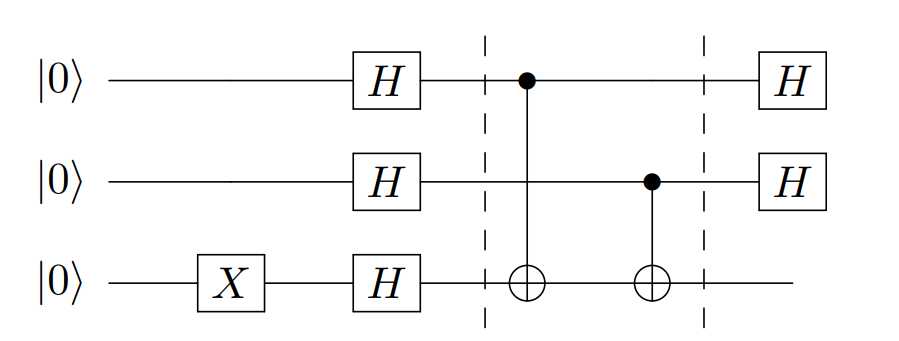

In [12]:
qc = QubitCircuit(N=3)
qc.add_gate("X", targets=2)
qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)
qc.add_gate("SNOT", targets=2)

# function f(x)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("CNOT", controls=1, targets=2)

qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)

In [13]:
processor = LinearSpinChain(3)
processor.load_circuit(qc);

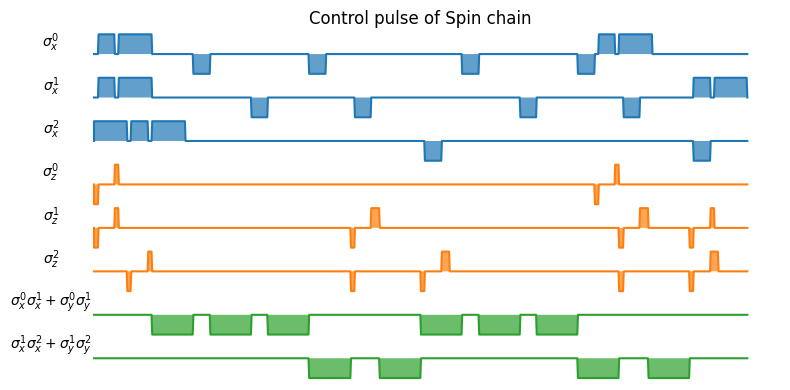

In [14]:
processor.plot_pulses(title="Control pulse of Spin chain", figsize=(8, 4), dpi=100);

### Without decoherence

In [15]:
basis00 = basis([2,2], [0,0])
psi0 = basis([2,2,2], [0,0,0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
1.543983026671485e-08


### With decoherence

In [16]:
processor.t1 = 100
processor.t2 = 30
psi0 = basis([2,2,2], [0,0,0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.13730255188167628
